En este notebook se almacena en pipeline final de todo el proceso de machine learning. Ademas, se procurar hacer uso lo maximo posible de las librerias open sur en python.

In [5]:
# Manipulación de imagenes y creación de graficas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Gurdar estructuras de datos
import joblib

# Creación de modelos
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# para realizar ing de caracteristicas
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# Para paralelizar
import preprocessors as pp

In [7]:
# Cargar los datos de entrenamiento
data = pd.read_csv('data/train.csv')

# Visualizar el data frame
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [8]:
# Tranformar varible categorica codificada como numero a categorica
data['MSSubClass'] = data['MSSubClass'].astype('O')

In [9]:
# Se separa el conjunto de datos en entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), # Variables predictoras
    data['SalePrice'], # Objetivo
    test_size=0.1, 
    random_state=0, 
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

In [10]:
y_train = np.log(y_train)
y_test = np.log(y_test)

# Configuración

Se crean aquellas constantes y diccionarios de recodificación

In [11]:
#
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure',
                                     'BsmtFinType1', 'GarageFinish']


CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']



NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"


DROP_FEATURES = ["YrSold"]


NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]



BINARIZE_VARS = ['ScreenPorch']


QUAL_VARS = ['ExterQual', 'BsmtQual',
             'HeatingQC', 'KitchenQual', 'FireplaceQu']

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']



CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']



QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}



FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
    "YrSold",
]

In [12]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 37), (146, 37))

# Pipeline

In [13]:
# definicion del pipeline
price_pipe = Pipeline([

    # ===== IMPUTACION =====
    # Imputación de las variables categoricas con el string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # Agregar indicadores de NA
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # Imputacion de lkas variables numericas con la media
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),
    
    
    # == VARIABLES TEMPORALES ====
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    ('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

   

    # ==== TRANFORMACION DE VARIABLES =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
#     ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),
    

    # === RECODIFICAR VARIABLES ===
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),


    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),

    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
    
    ('scaler', MinMaxScaler()),
#     ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))),
    ('Lasso', Lasso(alpha=0.001, random_state=0)),
])


In [14]:
# Entrenar el pipeline
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour', 'LotConfig',
                                           'Neighborhood', 'RoofStyle',
                                           'Exterior1st', 'Foundation',
                                           'CentralAir', 'Functional',
                                           'PavedDrive', 'SaleCondition'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.001, random_state=0))])

# Evaluación del modelo

In [16]:


pred = price_pipe.predict(X_train)

print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

pred = price_pipe.predict(X_test)


print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()


train mse: 781396630
train rmse: 27953
train r2: 0.8748530315439078

test mse: 1060769014
test rmse: 32569
test r2: 0.8456415571208442



Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

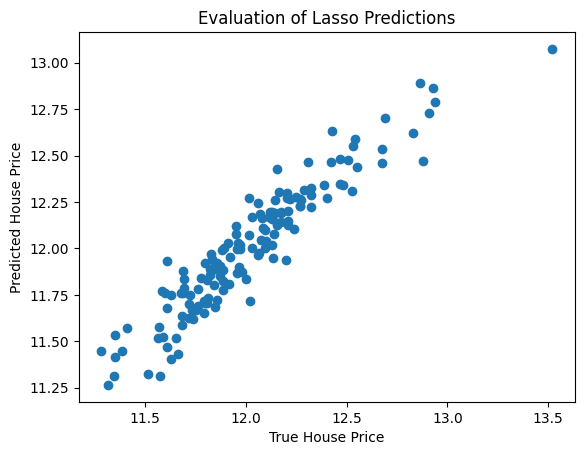

In [17]:
plt.scatter(y_test, price_pipe.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

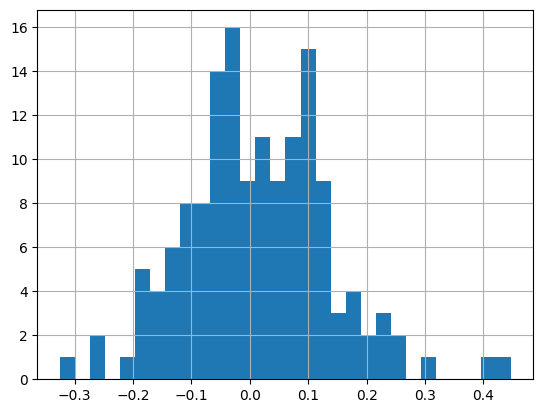

In [18]:
y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

# Predecir con el modelo

In [20]:

data = pd.read_csv('data/test.csv')

data.drop('Id', axis=1, inplace=True)

data['MSSubClass'] = data['MSSubClass'].astype('O')

data = data[FEATURES]

print(data.shape)

(1459, 37)


In [21]:
new_vars_with_na = [
    var for var in FEATURES
    if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT +
    CATEGORICAL_VARS_WITH_NA_MISSING +
    NUMERICAL_VARS_WITH_NA
    and data[var].isnull().sum() > 0]

new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

In [22]:
data[new_vars_with_na].head()

MSZoning Exterior1st  BsmtFullBath KitchenQual Functional  GarageCars  \
0       RH     VinylSd           0.0          TA        Typ         1.0   
1       RL     Wd Sdng           0.0          Gd        Typ         1.0   
2       RL     VinylSd           0.0          TA        Typ         2.0   
3       RL     VinylSd           0.0          Gd        Typ         2.0   
4       RL     HdBoard           0.0          Gd        Typ         2.0   

   GarageArea  
0       730.0  
1       312.0  
2       482.0  
3       470.0  
4       506.0

In [23]:
data[new_vars_with_na].isnull().mean()

MSZoning        0.002742
Exterior1st     0.000685
BsmtFullBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [24]:
data.dropna(subset=new_vars_with_na, inplace=True)

print(data.shape)

(1449, 37)


In [25]:
new_preds = price_pipe.predict(data)

<AxesSubplot: >

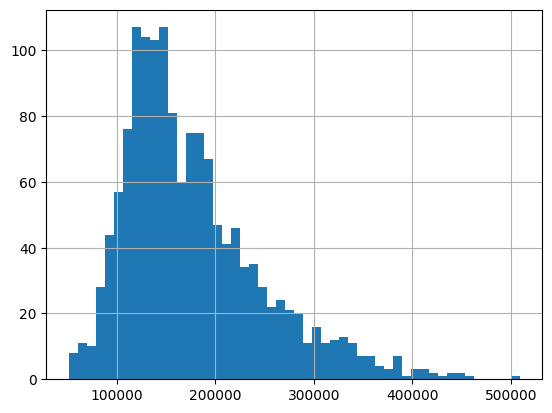

In [26]:
# 
pd.Series(np.exp(new_preds)).hist(bins=50)